# Diabetes Prediction -- Kaggle S5E12
## Full Pipeline: EDA -> Feature Engineering -> Optuna Tuning -> OOF Stacking -> Neural Net -> Blend
---
**Strategy:**
1. Rich EDA with beautiful visuals
2. 30+ Engineered Features (interactions, risk scores, clinical thresholds)
3. Leak-free OOF Target Encoding
4. Optuna Hyperparameter Search (XGBoost, CatBoost)
5. PyTorch Residual MLP Neural Network
6. Overfitting Analysis
7. OOF Stacking Meta-Learner
8. Smart Blend Selection

## 1.  Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import scipy.stats as stats

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme(style='darkgrid', font_scale=1.1)
PALETTE = ['#6C5CE7', '#00B894', '#FD79A8', '#0984E3', '#FDCB6E', '#E17055', '#74B9FF', '#55EFC4']
plt.rcParams.update({'figure.dpi': 120, 'axes.titleweight': 'bold',
                     'axes.titlesize': 13, 'axes.facecolor': '#1a1a2e',
                     'figure.facecolor': '#16213e', 'text.color': 'white',
                     'axes.labelcolor': 'white', 'xtick.color': 'white',
                     'ytick.color': 'white', 'grid.alpha': 0.3,
                     'grid.color': '#ffffff'})

SEED     = 42
N_FOLDS  = 5
N_TRIALS = 60
np.random.seed(SEED)

print('All imports done.')
print(f'   SEED={SEED} | FOLDS={N_FOLDS} | OPTUNA_TRIALS={N_TRIALS}')

All imports done.
   SEED=42 | FOLDS=5 | OPTUNA_TRIALS=60


In [2]:
# GPU / CPU Verification
import torch
import numpy as np

print("=" * 50)
print("  HARDWARE & FRAMEWORK CHECK")
print("=" * 50)

cuda_ok = torch.cuda.is_available()
print(f"\nCUDA available  : {'YES' if cuda_ok else 'NO'}")
if cuda_ok:
    for g in range(torch.cuda.device_count()):
        vram = torch.cuda.get_device_properties(g).total_memory / 1e9
        print(f"   GPU {g} : {torch.cuda.get_device_name(g)}  ({vram:.1f} GB VRAM)")

_X = np.random.randn(200, 10).astype(np.float32)
_y = np.random.randint(0, 2, 200)

try:
    from xgboost import XGBClassifier
    XGBClassifier(n_estimators=5, device='cuda', tree_method='hist', verbosity=0).fit(_X, _y)
    XGB_DEVICE = 'cuda'
    print("XGBoost CUDA    : OK -> GPU")
except Exception as e:
    XGB_DEVICE = 'cpu'
    print(f"XGBoost CUDA    : Fallback CPU ({str(e)[:60]})")

try:
    from catboost import CatBoostClassifier
    CatBoostClassifier(iterations=5, task_type='GPU', verbose=0).fit(_X, _y)
    CAT_TASK = 'GPU'
    print("CatBoost GPU    : OK -> GPU")
except Exception as e:
    CAT_TASK = 'CPU'
    print(f"CatBoost GPU    : Fallback CPU ({str(e)[:60]})")

NN_DEVICE = 'cuda' if cuda_ok else 'cpu'
print(f"Neural Net      : {NN_DEVICE.upper()}")
print("=" * 50)

  HARDWARE & FRAMEWORK CHECK

CUDA available  : YES
   GPU 0 : Tesla T4  (15.6 GB VRAM)
   GPU 1 : Tesla T4  (15.6 GB VRAM)
XGBoost CUDA    : OK -> GPU
CatBoost GPU    : OK -> GPU
Neural Net      : CUDA


## 2.  Load Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')

target   = 'diagnosed_diabetes'
test_ids = test['id'].values
y        = train[target].values.astype(np.float32)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

print(f'Train : {train.shape}  |  Test : {test.shape}')
print(f'Class balance  → Positive: {y.mean():.3f}  |  scale_pos_weight: {scale_pos_weight:.3f}')

num_cols_raw = [c for c in train.select_dtypes(include='number').columns if c not in ['id', target]]
cat_cols_raw = train.select_dtypes(include='object').columns.tolist()
print(f'\n Numeric features ({len(num_cols_raw)}): {num_cols_raw}')
print(f' Categorical features ({len(cat_cols_raw)}): {cat_cols_raw}')
train.head(3)

Train : (700000, 26)  |  Test : (300000, 25)
Class balance  → Positive: 0.623  |  scale_pos_weight: 0.604

 Numeric features (18): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
 Categorical features (6): ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0


## 3.  Exploratory Data Analysis

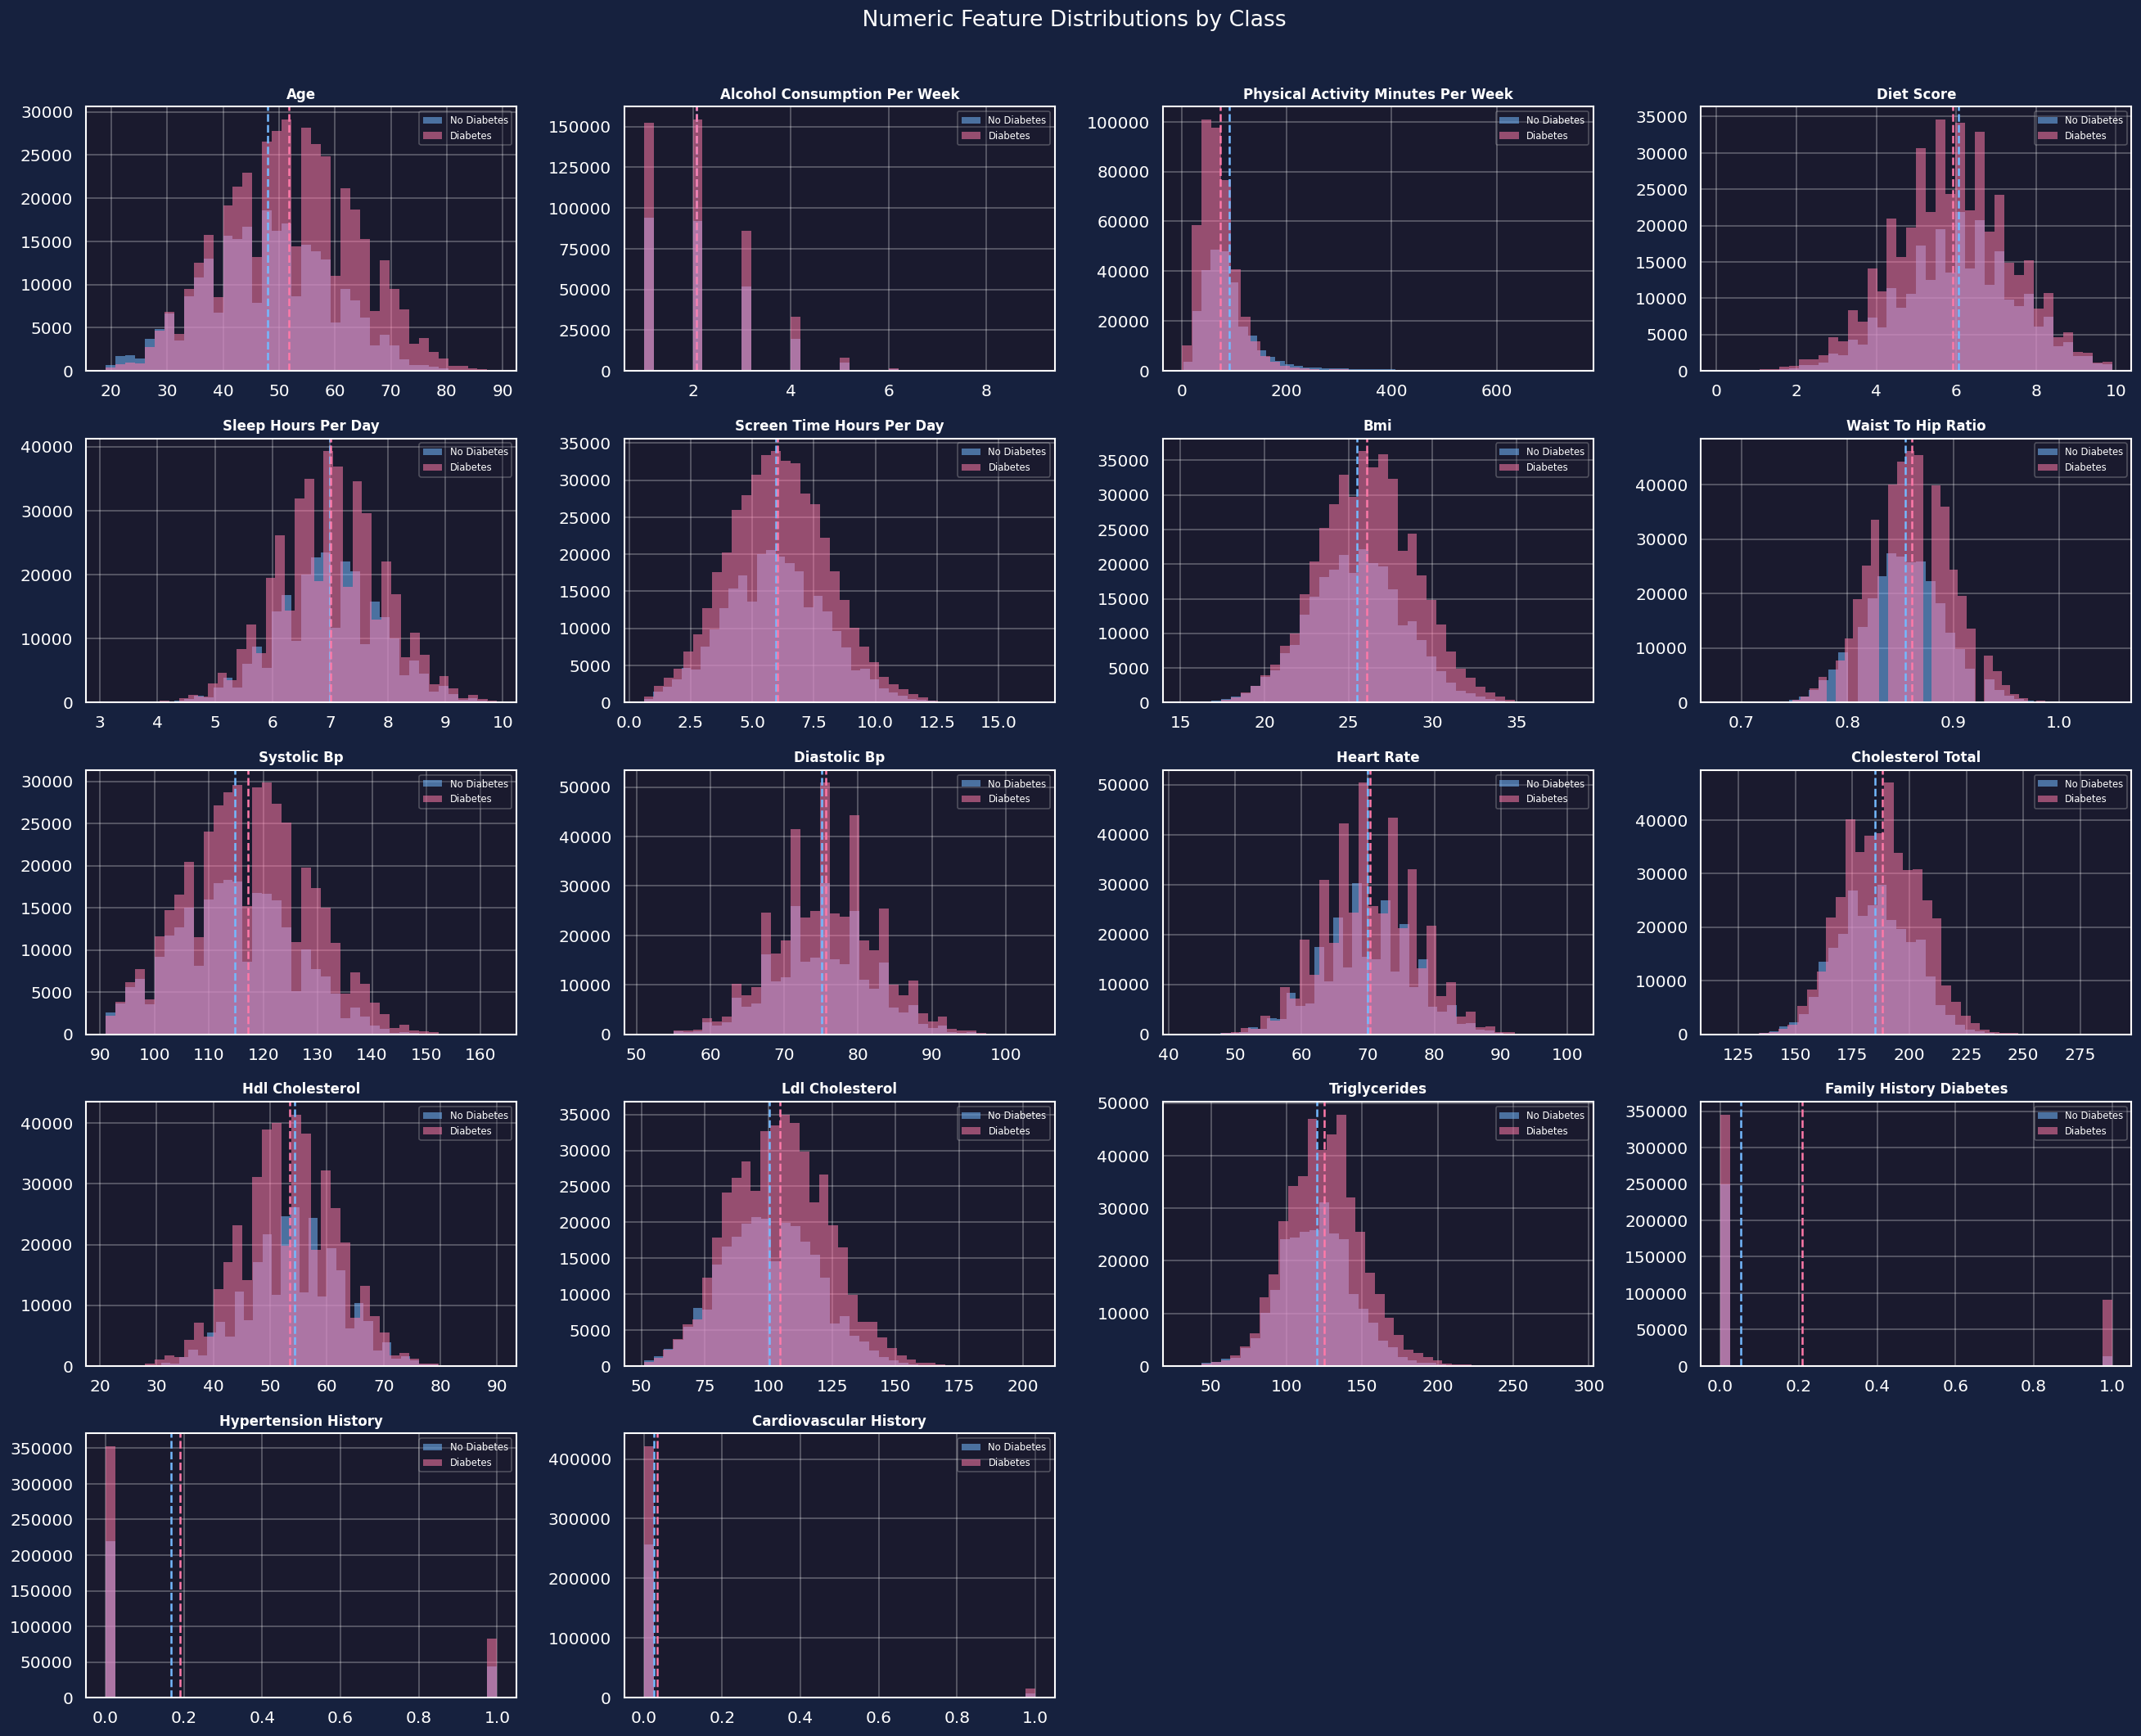

In [4]:
# ─── 3.1  Numeric distributions by class ──────────────────────────────────────
num_cols = [c for c in train.select_dtypes(include='number').columns if c not in ['id', target]]
cat_cols = train.select_dtypes(include='object').columns.tolist()

n = len(num_cols)
nrows, ncols = (n + 3) // 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(22, nrows * 3.5))
fig.suptitle(' Numeric Feature Distributions by Class', fontsize=16, y=1.01, color='white')

for i, col in enumerate(num_cols):
    ax = axes.flat[i]
    for cls, color, label in [(0, '#74B9FF', 'No Diabetes'), (1, '#FD79A8', 'Diabetes')]:
        data = train.loc[train[target] == cls, col].dropna()
        ax.hist(data, bins=40, alpha=0.55, color=color, label=label, edgecolor='none')
        ax.axvline(data.mean(), color=color, linestyle='--', linewidth=1.5)
    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.legend(fontsize=7, framealpha=0.3)
    ax.set_xlabel('')

for j in range(i + 1, len(axes.flat)):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

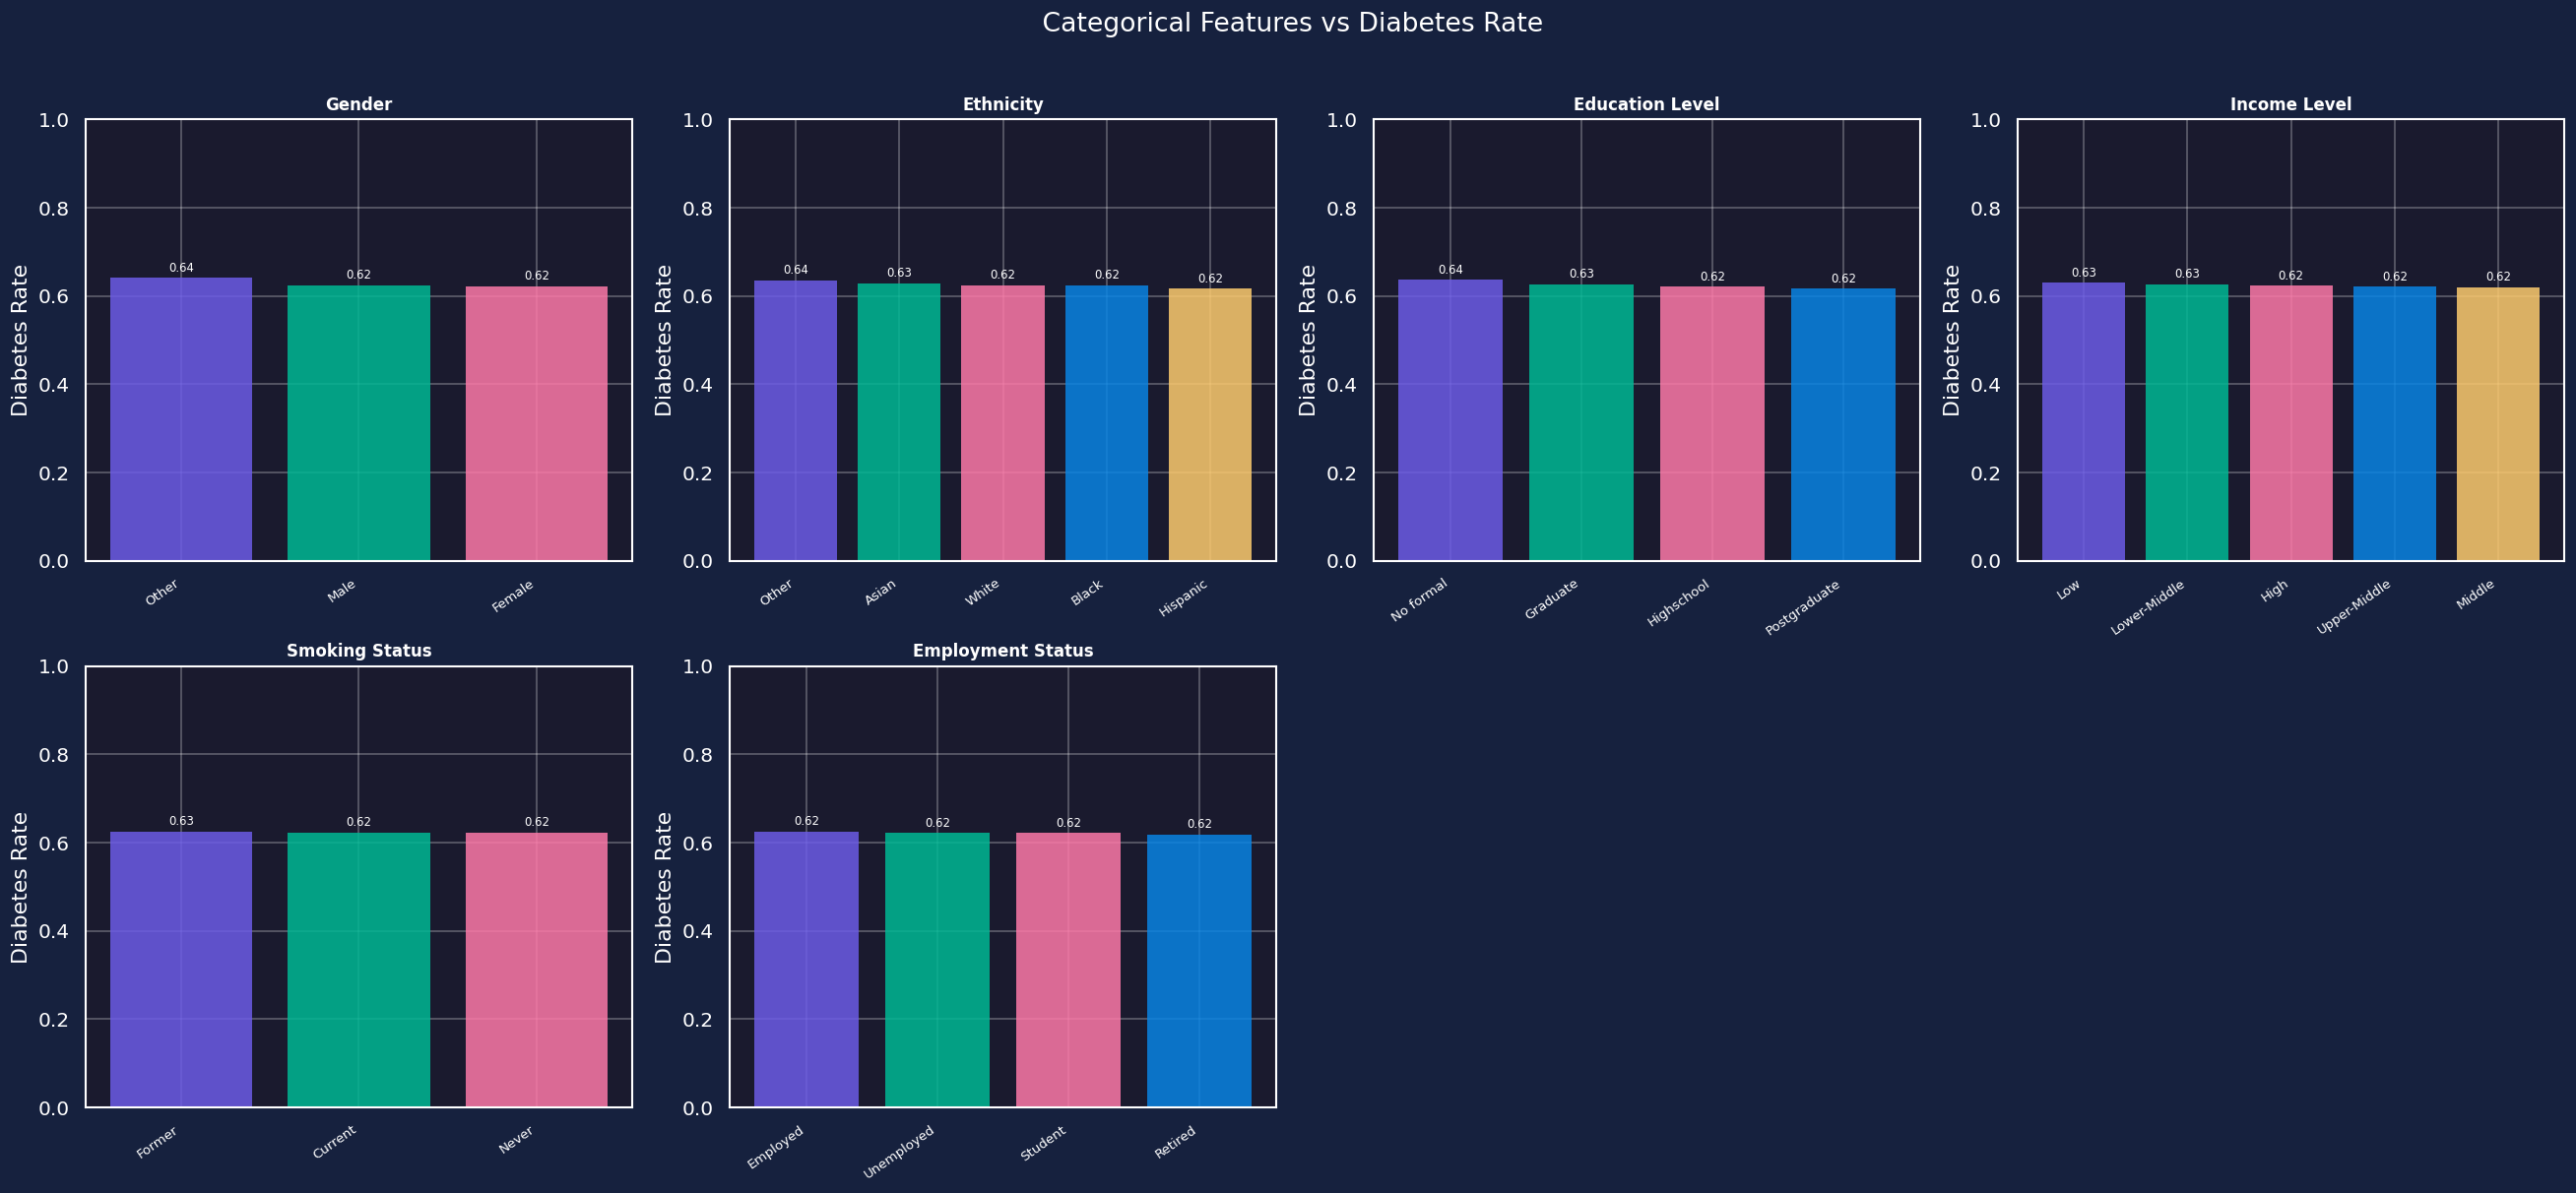

In [5]:
# ─── 3.2  Categorical features vs Target ──────────────────────────────────────
cat_cols = train.select_dtypes(include='object').columns.tolist()

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle(' Categorical Features vs Diabetes Rate', fontsize=16, y=1.01, color='white')

for i, col in enumerate(cat_cols[:8]):
    ax = axes.flat[i]
    rates = train.groupby(col)[target].mean().sort_values(ascending=False)
    bars = ax.bar(range(len(rates)), rates.values,
                  color=[PALETTE[j % len(PALETTE)] for j in range(len(rates))],
                  edgecolor='none', alpha=0.85)
    ax.set_xticks(range(len(rates)))
    ax.set_xticklabels(rates.index, rotation=35, ha='right', fontsize=8)
    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Diabetes Rate')
    ax.set_ylim(0, 1)
    for bar, val in zip(bars, rates.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
                f'{val:.2f}', ha='center', fontsize=7, color='white')

for j in range(len(cat_cols[:8]), 8):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

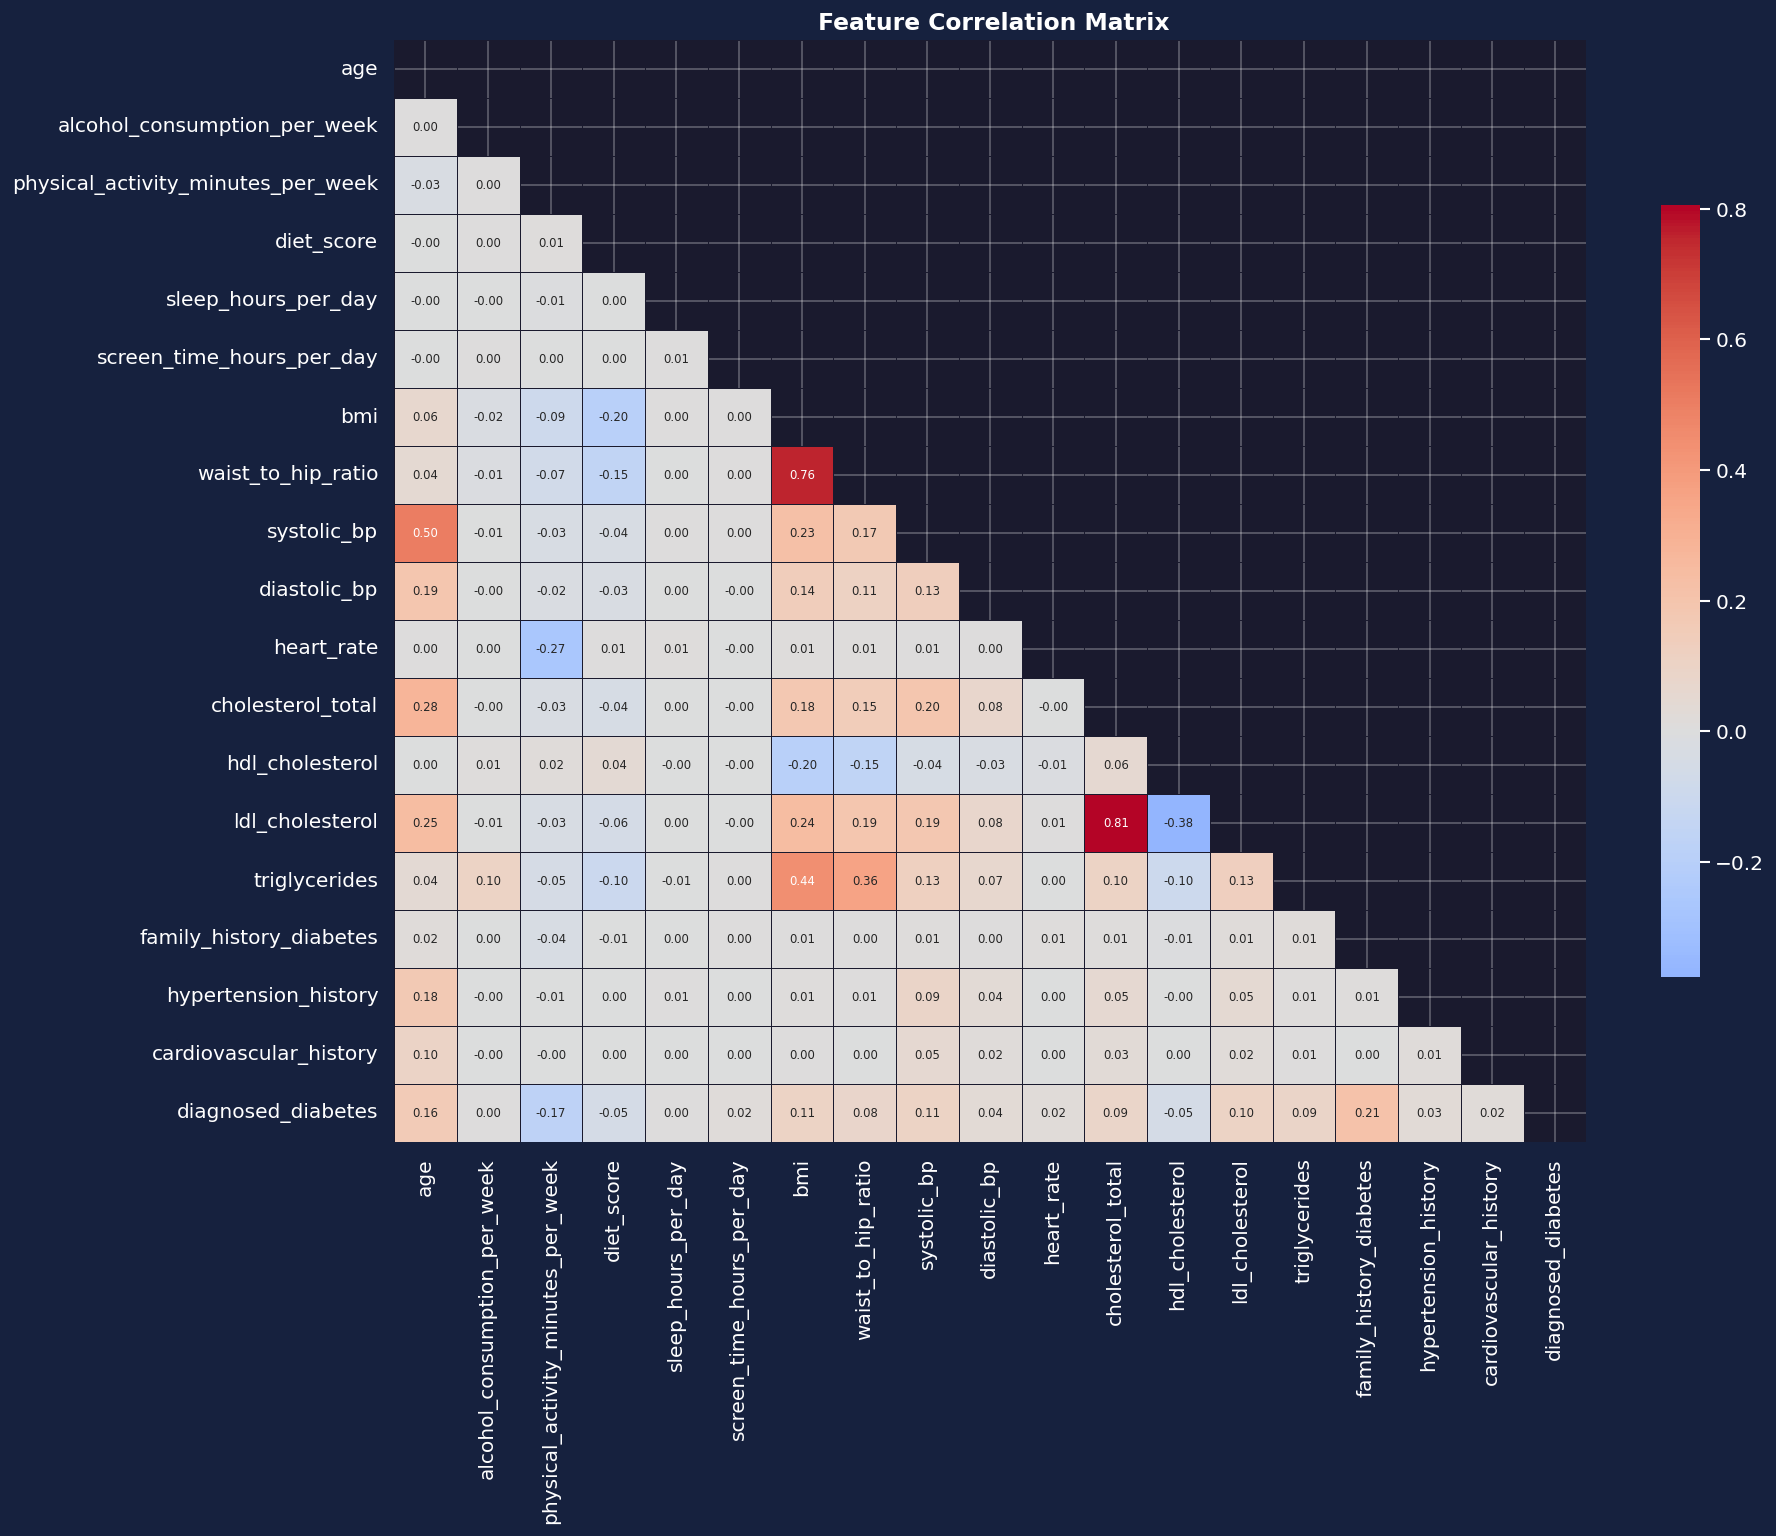


 Top correlations with diagnosed_diabetes:
family_history_diabetes               0.211064
physical_activity_minutes_per_week    0.169789
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
hdl_cholesterol                       0.053231
diet_score                            0.050119
diastolic_bp                          0.036271


In [6]:
# ─── 3.3  Correlation Heatmap ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 13))
corr = train[num_cols + [target]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.3, linecolor='#1a1a2e',
            ax=ax, annot_kws={'size': 7},
            cbar_kws={'shrink': 0.7})
ax.set_title(' Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Top corr with target
print('\n Top correlations with diagnosed_diabetes:')
print(corr[target].drop(target).abs().sort_values(ascending=False).head(12).to_string())

## 4.  Feature Engineering

In [7]:
def safe_col(df, col):
    """Return column if it exists, else None — prevents KeyError."""
    return df[col] if col in df.columns else None

def safe_mul(df, c1, c2):
    """Multiply two columns only if both exist."""
    if c1 in df.columns and c2 in df.columns:
        return df[c1] * df[c2]
    return None

def safe_div(df, c1, c2, eps=1e-6):
    """Divide two columns only if both exist."""
    if c1 in df.columns and c2 in df.columns:
        return df[c1] / (df[c2] + eps)
    return None

def engineer_features(df):
    df = df.copy()
    cols = df.columns.tolist()   # snapshot — check existence before adding

    # ── A) Clinical risk thresholds (only using actual available cols) ─────────
    if 'bmi' in cols:
        df['bmi_obese']          = (df['bmi'] >= 30).astype(int)
        df['bmi_overweight']     = ((df['bmi'] >= 25) & (df['bmi'] < 30)).astype(int)
        df['bmi_severely_obese'] = (df['bmi'] >= 35).astype(int)
        df['bmi_sq']             = df['bmi'] ** 2
        df['log_bmi']            = np.log1p(df['bmi'].clip(0))

    if 'systolic_bp' in cols:
        df['high_systolic_bp'] = (df['systolic_bp'] >= 130).astype(int)
        df['hypertensive']     = (df['systolic_bp'] >= 140).astype(int)

    if 'diastolic_bp' in cols:
        df['high_diastolic_bp'] = (df['diastolic_bp'] >= 80).astype(int)
        if 'systolic_bp' in cols:
            df['hypertensive']    = ((df['systolic_bp'] >= 140) | (df['diastolic_bp'] >= 90)).astype(int)
            df['bp_pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']

    if 'sleep_hours_per_day' in cols:
        df['poor_sleep']      = (df['sleep_hours_per_day'] < 6).astype(int)
        df['excessive_sleep'] = (df['sleep_hours_per_day'] > 9).astype(int)

    if 'screen_time_hours_per_day' in cols:
        df['high_screen_time'] = (df['screen_time_hours_per_day'] > 8).astype(int)

    if 'physical_activity_minutes_per_week' in cols:
        df['sedentary'] = (df['physical_activity_minutes_per_week'] < 75).astype(int)

    if 'alcohol_consumption_per_week' in cols:
        df['heavy_drinker'] = (df['alcohol_consumption_per_week'] > 14).astype(int)

    if 'age' in cols:
        df['elderly']     = (df['age'] >= 65).astype(int)
        df['middle_aged'] = ((df['age'] >= 45) & (df['age'] < 65)).astype(int)
        df['age_sq']      = df['age'] ** 2
        df['log_age']     = np.log1p(df['age'])

    # ── B) Interaction features (conditional) ─────────────────────────────────
    v = safe_mul(df, 'bmi', 'age')
    if v is not None: df['bmi_x_age'] = v

    v = safe_mul(df, 'bmi', 'physical_activity_minutes_per_week')
    if v is not None: df['bmi_x_physical'] = v

    v = safe_mul(df, 'bmi', 'waist_to_hip_ratio')
    if v is not None: df['bmi_x_waist'] = v

    v = safe_mul(df, 'diet_score', 'physical_activity_minutes_per_week')
    if v is not None: df['diet_x_physical'] = v

    v = safe_mul(df, 'age', 'family_history_diabetes')
    if v is not None: df['age_x_fam_history'] = v

    v = safe_mul(df, 'bmi', 'hypertension_history')
    if v is not None: df['bmi_x_hypertension'] = v

    v = safe_mul(df, 'age', 'hypertension_history')
    if v is not None: df['age_x_hypertension'] = v

    v = safe_mul(df, 'age', 'cardiovascular_history')
    if v is not None: df['age_x_cardiovascular'] = v

    # ── Conditional on clinical labs (may or may not exist) ──────────────────
    v = safe_mul(df, 'fasting_blood_glucose_level', 'hba1c_level')
    if v is not None: df['fasting_x_hba1c'] = v

    v = safe_div(df, 'fasting_blood_glucose_level', 'age')
    if v is not None: df['glucose_to_age'] = v

    v = safe_div(df, 'total_cholesterol', 'hdl_cholesterol')
    if v is not None: df['cholesterol_ratio'] = v

    v = safe_div(df, 'ldl_cholesterol', 'hdl_cholesterol')
    if v is not None: df['ldl_hdl_ratio'] = v

    if 'diastolic_bp' in cols and 'age' in cols:
        df['bp_x_age'] = df['diastolic_bp'] * df['age']

    # Poly/log for any clinical lab cols that DO exist
    for col in ['fasting_blood_glucose_level', 'hba1c_level',
                'total_cholesterol', 'hdl_cholesterol', 'ldl_cholesterol']:
        if col in df.columns:
            df[f'{col}_sq']  = df[col] ** 2
            df[f'log_{col}'] = np.log1p(df[col].clip(0))

    # ── C) Ratio features ────────────────────────────────────────────────────
    if 'sleep_hours_per_day' in cols and 'screen_time_hours_per_day' in cols:
        df['sleep_to_screen'] = df['sleep_hours_per_day'] / (df['screen_time_hours_per_day'] + 0.1)

    if 'physical_activity_minutes_per_week' in cols and 'age' in cols:
        df['activity_per_age'] = df['physical_activity_minutes_per_week'] / (df['age'] + 1)

    # ── D) Composite risk score (only from cols that exist now) ───────────────
    risk_candidates = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
                       'bmi_obese', 'sedentary', 'poor_sleep', 'heavy_drinker',
                       'high_systolic_bp', 'elderly', 'high_screen_time']
    available_risk = [c for c in risk_candidates if c in df.columns]
    df['composite_risk_score'] = df[available_risk].sum(axis=1)
    df['risk_score_sq']        = df['composite_risk_score'] ** 2

    return df

train = engineer_features(train)
test  = engineer_features(test)

new_features = [c for c in train.columns if c not in ['id', target] + num_cols + cat_cols]
print(f' Feature engineering done!')
print(f'   Original numeric : {len(num_cols)}')
print(f'   New features     : {len(new_features)}')
print(f'   Total columns    : {train.shape[1]}')

 Feature engineering done!
   Original numeric : 18
   New features     : 36
   Total columns    : 62


## 5.  Preprocessing

In [8]:
# ─── 5.1  Outlier capping (IQR) — after feature engineering ──────────────────
def cap_outliers(df, exclude=None, lower_q=0.01, upper_q=0.99):
    """Percentile-based capping — gentler than IQR for dense features."""
    exclude = exclude or []
    df = df.copy()
    for col in df.select_dtypes(include='number').columns:
        if col in exclude:
            continue
        lo, hi = df[col].quantile(lower_q), df[col].quantile(upper_q)
        df[col] = df[col].clip(lo, hi)
    return df

train = cap_outliers(train, exclude=['id', target])
test  = cap_outliers(test,  exclude=['id'])
print(' Outlier capping done.')

 Outlier capping done.


In [9]:
# ─── 5.2  Categorical encoding ────────────────────────────────────────────────
# Ordinal columns with a natural order
ordinal_map = {
    'education_level'  : ['No Formal Education', 'Primary', 'Highschool', 'Bachelor', 'Postgraduate'],
    'income_level'     : ['Low', 'Lower-Middle', 'Upper-Middle', 'High'],
    'smoking_status'   : ['Never', 'Former', 'Current'],
    'employment_status': ['Unemployed', 'Retired', 'Part-time', 'Employed'],
}
nominal_cols = ['gender', 'ethnicity']   # one-hot / label encode

all_data = pd.concat([train.drop(columns=[target]), test], ignore_index=True)

# Ordinal encoding
for col, order in ordinal_map.items():
    if col in all_data.columns:
        known = [v for v in order if v in all_data[col].unique()]
        unknown = [v for v in all_data[col].unique() if v not in order]
        full_order = known + unknown
        cat_type = pd.CategoricalDtype(categories=full_order, ordered=True)
        all_data[col] = all_data[col].astype(cat_type).cat.codes

# Label encode nominal
for col in nominal_cols:
    if col in all_data.columns:
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col].astype(str))

train_proc = all_data.iloc[:len(train)].copy()
test_proc  = all_data.iloc[len(train):].copy()
print(f' Categorical encoding done. Shape: {train_proc.shape}')

 Categorical encoding done. Shape: (700000, 61)


In [10]:
# ─── 5.3  Leak-free OOF Target Encoding ──────────────────────────────────────
def oof_target_encode(train_df, test_df, cols, target_vals, n_folds=5, smooth=20, seed=42):
    """Smoothed OOF target encoding — zero data leakage."""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    global_mean = target_vals.mean()

    train_out = train_df.copy()
    test_out  = test_df.copy()

    for col in cols:
        if col not in train_df.columns:
            continue
        te_col = f'{col}_te'
        train_out[te_col] = 0.0
        test_te_folds     = np.zeros(len(test_df))

        for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, target_vals)):
            stats_map = (
                pd.Series(target_vals[trn_idx], name=target)
                .groupby(train_df[col].iloc[trn_idx]).agg(['mean', 'count'])
            )
            smoothed = (stats_map['mean'] * stats_map['count'] + global_mean * smooth) / \
                       (stats_map['count'] + smooth)
            train_out.loc[val_idx, te_col] = train_df[col].iloc[val_idx].map(smoothed).fillna(global_mean)
            test_te_folds += test_df[col].map(smoothed).fillna(global_mean).values / n_folds

        test_out[te_col] = test_te_folds

    return train_out, test_out

# Encode original categoricals + high-cardinality engineered feats
encode_cols = [c for c in ordinal_map.keys() if c in train_proc.columns] + nominal_cols

train_enc, test_enc = oof_target_encode(
    train_proc, test_proc, cols=encode_cols,
    target_vals=y, n_folds=N_FOLDS, smooth=20, seed=SEED
)

print(f' OOF Target Encoding done. New cols added: {len(encode_cols)}')
print(f'   Encoded: {encode_cols}')

 OOF Target Encoding done. New cols added: 6
   Encoded: ['education_level', 'income_level', 'smoking_status', 'employment_status', 'gender', 'ethnicity']


In [11]:
# ─── 5.4  Prepare final feature matrices ─────────────────────────────────────
drop_cols = ['id']
feature_cols = [c for c in train_enc.columns if c not in drop_cols]

X      = train_enc[feature_cols].values.astype(np.float32)
X_test = test_enc[feature_cols].values.astype(np.float32)

# Scale for neural net (keep raw for trees)
scaler  = StandardScaler()
X_sc    = scaler.fit_transform(X)
X_test_sc = scaler.transform(X_test)

print(f' Final feature matrix ready.')
print(f'   X shape: {X.shape}  |  X_test shape: {X_test.shape}')

 Final feature matrix ready.
   X shape: (700000, 66)  |  X_test shape: (300000, 66)


## 6.  Optuna Hyperparameter Tuning

In [12]:
# Shared CV object
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

def cv_auc(model, X_, y_, skf_):
    aucs = []
    for trn, val in skf_.split(X_, y_):
        model.fit(X_[trn], y_[trn])
        aucs.append(roc_auc_score(y_[val], model.predict_proba(X_[val])[:, 1]))
    return np.mean(aucs)

In [13]:
# ══════════════════════════════════════════════════════════════════════════════
# XGBoost objective
# ══════════════════════════════════════════════════════════════════════════════
def objective_xgb(trial):
    params = {
        'n_estimators'   : trial.suggest_int('n_estimators', 400, 2000),
        'learning_rate'  : trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth'      : trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample'      : trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha'      : trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda'     : trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'gamma'          : trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric'    : 'auc', 'random_state': SEED,
        'tree_method'    : 'hist', 'device': 'cuda',
    }
    model = XGBClassifier(**params)
    return cv_auc(model, X, y, skf)

print(' Tuning XGBoost...')
study_xgb = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True)
print(f'  Best XGBoost AUC : {study_xgb.best_value:.5f}')

 Tuning XGBoost...


  0%|          | 0/60 [00:00<?, ?it/s]

  Best XGBoost AUC : 0.72684


In [14]:
# ══════════════════════════════════════════════════════════════════════════════
# CatBoost objective
# ══════════════════════════════════════════════════════════════════════════════
def objective_cat(trial):
    params = {
        'iterations'       : trial.suggest_int('iterations', 400, 2000),
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'depth'            : trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg'      : trial.suggest_float('l2_leaf_reg', 1e-3, 20, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5),
        'random_strength'  : trial.suggest_float('random_strength', 0, 5),
        'border_count'     : trial.suggest_int('border_count', 32, 255),
        'auto_class_weights': 'Balanced',
        'eval_metric'      : 'AUC', 'random_seed': SEED,
        'task_type'        : 'GPU', 'verbose': 0,
    }
    model = CatBoostClassifier(**params)
    return cv_auc(model, X, y, skf)

print(' Tuning CatBoost...')
study_cat = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
study_cat.optimize(objective_cat, n_trials=N_TRIALS, show_progress_bar=True)
print(f'  Best CatBoost AUC: {study_cat.best_value:.5f}')

 Tuning CatBoost...


  0%|          | 0/60 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

  Best CatBoost AUC: 0.72557


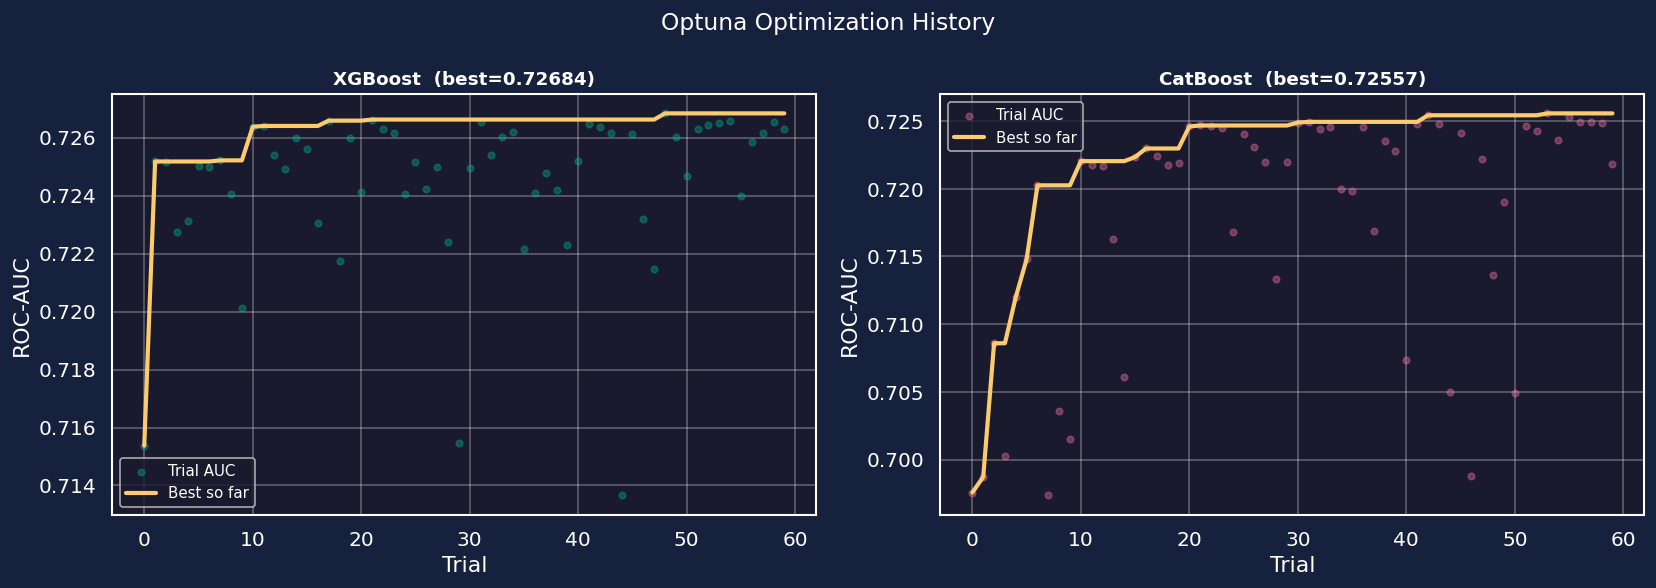

In [15]:
# Optuna Tuning Progress Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Optuna Optimization History', fontsize=14, color='white')

for ax, study, name, color in zip(axes,
                                   [study_xgb, study_cat],
                                   ['XGBoost', 'CatBoost'],
                                   ['#00B894', '#FD79A8']):
    trials     = [t.value for t in study.trials if t.value is not None]
    best_curve = pd.Series(trials).cummax()
    ax.scatter(range(len(trials)), trials, alpha=0.35, s=15, color=color, label='Trial AUC')
    ax.plot(best_curve, color='#FDCB6E', linewidth=2.5, label='Best so far')
    ax.set_title(f'{name}  (best={study.best_value:.5f})', fontsize=11)
    ax.set_xlabel('Trial')
    ax.set_ylabel('ROC-AUC')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## 7.  OOF Training + Overfitting Analysis

In [16]:
def build_model(name):
    if name == 'xgb':
        p = study_xgb.best_params.copy()
        p.update({'scale_pos_weight': scale_pos_weight, 'eval_metric': 'auc',
                  'random_state': SEED, 'tree_method': 'hist', 'device': XGB_DEVICE})
        return XGBClassifier(**p)
    elif name == 'cat':
        p = study_cat.best_params.copy()
        p.update({'auto_class_weights': 'Balanced', 'eval_metric': 'AUC',
                  'random_seed': SEED, 'task_type': CAT_TASK, 'verbose': 0})
        return CatBoostClassifier(**p)

oof_preds     = {name: np.zeros(len(X))      for name in ['xgb', 'cat']}
test_preds    = {name: np.zeros(len(X_test)) for name in ['xgb', 'cat']}
fold_aucs_all = {name: []                    for name in ['xgb', 'cat']}

skf_final = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for name in ['xgb', 'cat']:
    print(f'\nTraining {name.upper()} -- {N_FOLDS}-Fold OOF ...')
    for fold, (trn_idx, val_idx) in enumerate(skf_final.split(X, y)):
        X_trn, X_val = X[trn_idx], X[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]

        model = build_model(name)
        model.fit(X_trn, y_trn)

        val_prob  = model.predict_proba(X_val)[:, 1]
        oof_preds[name][val_idx] = val_prob
        test_preds[name] += model.predict_proba(X_test)[:, 1] / N_FOLDS

        train_prob = model.predict_proba(X_trn)[:, 1]
        trn_auc = roc_auc_score(y_trn, train_prob)
        val_auc = roc_auc_score(y_val, val_prob)
        fold_aucs_all[name].append((trn_auc, val_auc))
        print(f'  Fold {fold+1}  Train AUC: {trn_auc:.5f}  Val AUC: {val_auc:.5f}  '
              f'Gap: {trn_auc - val_auc:.5f}')

    oof_auc = roc_auc_score(y, oof_preds[name])
    print(f'  OOF AUC: {oof_auc:.5f}')


Training XGB -- 5-Fold OOF ...
  Fold 1  Train AUC: 0.74376  Val AUC: 0.72699  Gap: 0.01677
  Fold 2  Train AUC: 0.74421  Val AUC: 0.72539  Gap: 0.01882
  Fold 3  Train AUC: 0.74361  Val AUC: 0.72683  Gap: 0.01679
  Fold 4  Train AUC: 0.74360  Val AUC: 0.72772  Gap: 0.01588
  Fold 5  Train AUC: 0.74366  Val AUC: 0.72726  Gap: 0.01640
  OOF AUC: 0.72680

Training CAT -- 5-Fold OOF ...


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 1  Train AUC: 0.76073  Val AUC: 0.72559  Gap: 0.03513


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 2  Train AUC: 0.76105  Val AUC: 0.72428  Gap: 0.03677


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 3  Train AUC: 0.76056  Val AUC: 0.72562  Gap: 0.03494


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 4  Train AUC: 0.76064  Val AUC: 0.72652  Gap: 0.03412


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 5  Train AUC: 0.76078  Val AUC: 0.72621  Gap: 0.03457
  OOF AUC: 0.72564


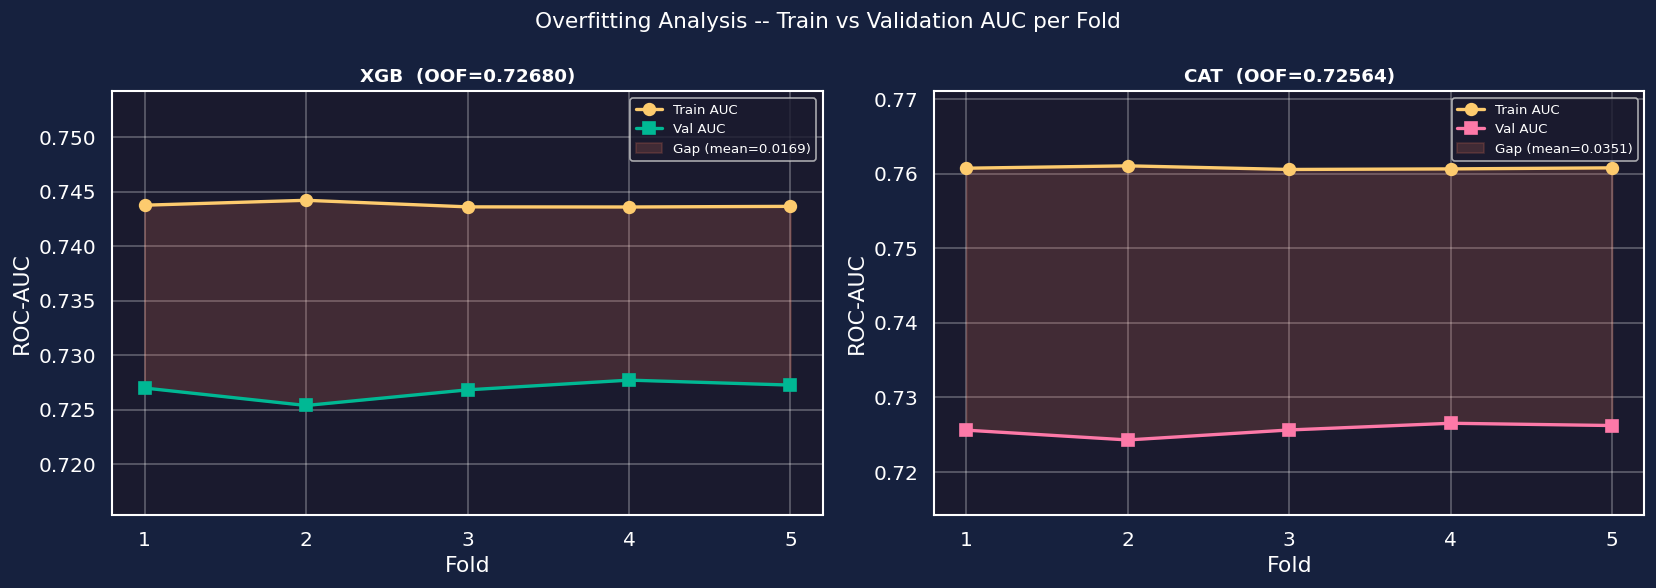

In [17]:
# Overfitting Analysis Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Overfitting Analysis -- Train vs Validation AUC per Fold', fontsize=13, color='white')

for ax, name, color in zip(axes, ['xgb', 'cat'], ['#00B894', '#FD79A8']):
    trn_aucs = [x[0] for x in fold_aucs_all[name]]
    val_aucs = [x[1] for x in fold_aucs_all[name]]
    folds    = list(range(1, N_FOLDS + 1))
    gaps     = [t - v for t, v in zip(trn_aucs, val_aucs)]

    ax.plot(folds, trn_aucs, 'o-', color='#FDCB6E', linewidth=2, markersize=7, label='Train AUC')
    ax.plot(folds, val_aucs, 's-', color=color,     linewidth=2, markersize=7, label='Val AUC')
    ax.fill_between(folds, val_aucs, trn_aucs, alpha=0.2, color='#E17055',
                    label=f'Gap (mean={np.mean(gaps):.4f})')
    ax.set_title(f'{name.upper()}  (OOF={roc_auc_score(y, oof_preds[name]):.5f})', fontsize=11)
    ax.set_xlabel('Fold')
    ax.set_ylabel('ROC-AUC')
    ax.set_xticks(folds)
    ax.legend(fontsize=8)
    ax.set_ylim(min(val_aucs) - 0.01, max(trn_aucs) + 0.01)

plt.tight_layout()
plt.show()

## 8.  Neural Network (PyTorch MLP)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f' Using device: {DEVICE}')

class ResidualMLP(nn.Module):
    """Deep residual MLP with dropout and batch-norm — good for tabular data."""
    def __init__(self, in_dim, hidden=512, n_blocks=4, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.BatchNorm1d(hidden),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden),
                nn.BatchNorm1d(hidden),
            ) for _ in range(n_blocks)
        ])
        self.out = nn.Sequential(
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden, 1),
        )
        self.act = nn.GELU()

    def forward(self, x):
        x = self.act(self.input_proj(x))
        for block in self.blocks:
            x = self.act(x + block(x))   # residual connection
        return self.out(x).squeeze(1)

def train_nn_fold(X_trn, y_trn, X_val, y_val, in_dim, epochs=100, bs=4096, lr=3e-4):
    model = ResidualMLP(in_dim).to(DEVICE)
    pos_weight = torch.tensor([(y_trn == 0).sum() / (y_trn == 1).sum()]).to(DEVICE)
    criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer  = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    Xt = torch.tensor(X_trn, dtype=torch.float32).to(DEVICE)
    yt = torch.tensor(y_trn, dtype=torch.float32).to(DEVICE)
    Xv = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    yv = torch.tensor(y_val, dtype=torch.float32).to(DEVICE)

    loader = DataLoader(TensorDataset(Xt, yt), batch_size=bs, shuffle=True, pin_memory=False)

    best_auc, best_state = 0, None
    for epoch in range(epochs):
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            criterion(model(xb), yb).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                logits = model(Xv)
                prob   = torch.sigmoid(logits).cpu().numpy()
            auc = roc_auc_score(y_val, prob)
            if auc > best_auc:
                best_auc = auc
                best_state = {k: v.clone() for k, v in model.state_dict().items()}

    # Final eval with best weights
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        val_prob  = torch.sigmoid(model(Xv)).cpu().numpy()
        test_prob = torch.sigmoid(
            model(torch.tensor(X_test_sc, dtype=torch.float32).to(DEVICE))
        ).cpu().numpy()
    return val_prob, test_prob, best_auc

print(' Training Neural Network (Residual MLP) — 5-Fold OOF ...')
oof_nn   = np.zeros(len(X_sc))
test_nn  = np.zeros(len(X_test_sc))
nn_aucs  = []

for fold, (trn_idx, val_idx) in enumerate(skf_final.split(X_sc, y)):
    val_prob, test_prob, fold_auc = train_nn_fold(
        X_sc[trn_idx], y[trn_idx],
        X_sc[val_idx],  y[val_idx],
        in_dim=X_sc.shape[1], epochs=120, bs=4096
    )
    oof_nn[val_idx] = val_prob
    test_nn        += test_prob / N_FOLDS
    nn_aucs.append(fold_auc)
    print(f'  Fold {fold+1}  Val AUC: {fold_auc:.5f}')

oof_nn_auc = roc_auc_score(y, oof_nn)
print(f'   Neural Net OOF AUC: {oof_nn_auc:.5f}  (mean folds: {np.mean(nn_aucs):.5f})')

 Using device: cuda
 Training Neural Network (Residual MLP) — 5-Fold OOF ...
  Fold 1  Val AUC: 0.69554
  Fold 2  Val AUC: 0.69459
  Fold 3  Val AUC: 0.69429
  Fold 4  Val AUC: 0.69607
  Fold 5  Val AUC: 0.69626
   Neural Net OOF AUC: 0.69520  (mean folds: 0.69535)


## 9.  OOF Stacking Meta-Learner

In [19]:
# Stack OOF predictions as features for meta-learner
meta_X_train = np.column_stack([
    oof_preds['xgb'],
    oof_preds['cat'],
    oof_nn
])
meta_X_test = np.column_stack([
    test_preds['xgb'],
    test_preds['cat'],
    test_nn
])

meta_lr = LogisticRegression(C=1.0, max_iter=1000, random_state=SEED)
meta_aucs = cross_val_score(meta_lr, meta_X_train, y,
                             cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                             scoring='roc_auc')
print(f'Meta-LR CV AUC : {np.mean(meta_aucs):.5f} +/- {np.std(meta_aucs):.5f}')

meta_lr.fit(meta_X_train, y)
test_stack = meta_lr.predict_proba(meta_X_test)[:, 1]
stack_oof  = meta_lr.predict_proba(meta_X_train)[:, 1]

print(f'  Meta coefs: XGB={meta_lr.coef_[0][0]:.3f}  '
      f'CatBoost={meta_lr.coef_[0][1]:.3f}  NN={meta_lr.coef_[0][2]:.3f}')

Meta-LR CV AUC : 0.72735 +/- 0.00075
  Meta coefs: XGB=2.774  CatBoost=2.448  NN=-0.584


## 10.  Blend Selection

In [20]:
# Blend strategies (weights: XGB, CatBoost, NN)
blend_configs = {
    'Equal (1/3 each)' : [1/3, 1/3, 1/3],
    'XGBoost heavy'    : [0.50, 0.25, 0.25],
    'CatBoost heavy'   : [0.25, 0.50, 0.25],
    'NN heavy'         : [0.25, 0.25, 0.50],
    'No NN'            : [0.50, 0.50, 0.00],
    'Stacking meta-LR' : [0.00, 0.00, 0.00],
}

results = {}
for key, weights in blend_configs.items():
    if key == 'Stacking meta-LR':
        blend_oof = stack_oof
    else:
        blend_oof = (
            weights[0] * oof_preds['xgb'] +
            weights[1] * oof_preds['cat'] +
            weights[2] * oof_nn
        )
    auc = roc_auc_score(y, blend_oof)
    results[key] = auc
    print(f'{key:25s}  OOF AUC: {auc:.5f}')

best_key = max(results, key=results.get)
best_auc = results[best_key]
print(f'\nBest strategy: {best_key}  AUC: {best_auc:.5f}')

best_weights = blend_configs[best_key]
if best_key == 'Stacking meta-LR':
    test_final_probs = test_stack
else:
    test_final_probs = (
        best_weights[0] * test_preds['xgb'] +
        best_weights[1] * test_preds['cat'] +
        best_weights[2] * test_nn
    )

Equal (1/3 each)           OOF AUC: 0.72275
XGBoost heavy              OOF AUC: 0.72444
CatBoost heavy             OOF AUC: 0.72400
NN heavy                   OOF AUC: 0.71854
No NN                      OOF AUC: 0.72688
Stacking meta-LR           OOF AUC: 0.72733

Best strategy: Stacking meta-LR  AUC: 0.72733


## 11.  Feature Importance Dashboard

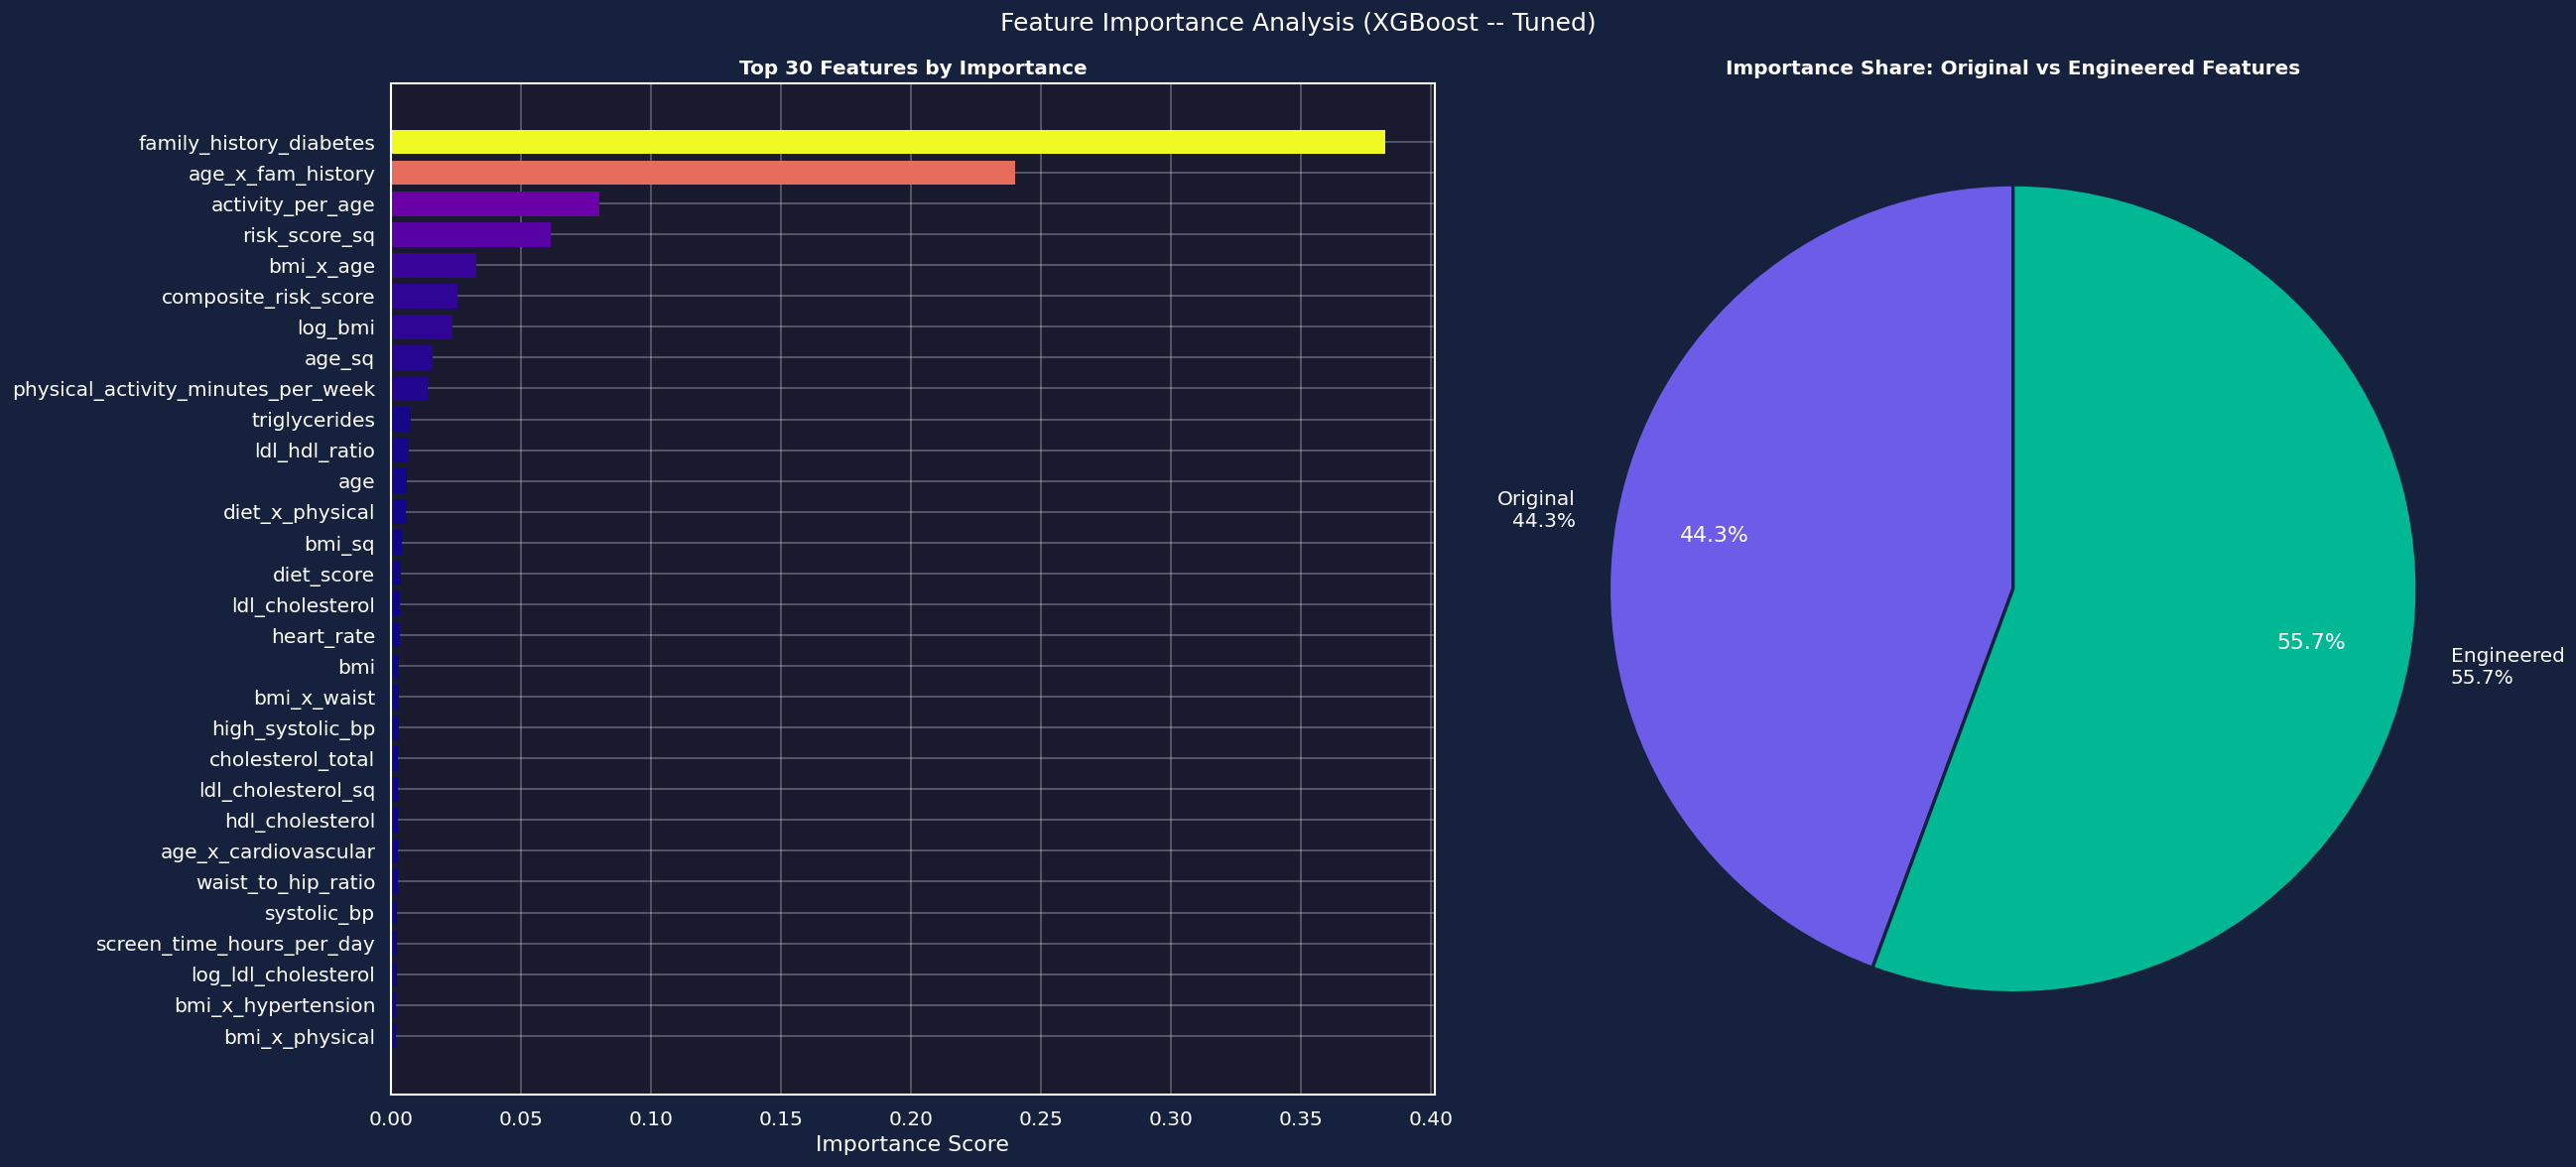

In [21]:
# Feature importance via XGBoost (trained on full data)
p_fi = study_xgb.best_params.copy()
p_fi.update({'scale_pos_weight': scale_pos_weight, 'eval_metric': 'auc',
             'random_state': SEED, 'tree_method': 'hist', 'device': XGB_DEVICE})
final_xgb = XGBClassifier(**p_fi)
final_xgb.fit(X, y)

feat_imp = pd.Series(final_xgb.feature_importances_,
                     index=feature_cols).sort_values(ascending=False)

top30     = feat_imp.head(30)
norm_vals = (top30.values - top30.min()) / (top30.max() - top30.min() + 1e-9)
cmap      = plt.cm.get_cmap('plasma')
colors    = [cmap(v) for v in norm_vals]

fig, axes = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle('Feature Importance Analysis (XGBoost -- Tuned)', fontsize=15, color='white')

axes[0].barh(top30.index[::-1], top30.values[::-1], color=colors[::-1], edgecolor='none')
axes[0].set_title('Top 30 Features by Importance', fontsize=12)
axes[0].set_xlabel('Importance Score')

orig_feats = [c for c in feature_cols if c in num_cols]
eng_feats  = [c for c in feature_cols if c not in num_cols + ['id']]
orig_imp   = feat_imp[orig_feats].sum()
eng_imp    = feat_imp[eng_feats].sum()

axes[1].pie(
    [orig_imp, eng_imp],
    labels=[f'Original\n{orig_imp/(orig_imp+eng_imp):.1%}',
            f'Engineered\n{eng_imp/(orig_imp+eng_imp):.1%}'],
    colors=['#6C5CE7', '#00B894'],
    autopct='%1.1f%%', pctdistance=0.75, startangle=90,
    wedgeprops={'edgecolor': '#16213e', 'linewidth': 2},
    textprops={'color': 'white'}
)
axes[1].set_title('Importance Share: Original vs Engineered Features', fontsize=12)

plt.tight_layout()
plt.show()

## 12.  Final Results Dashboard

       FINAL OOF RESULTS
                        Model  OOF AUC
Best Blend (Stacking meta-LR) 0.727331
                      XGBoost 0.726804
                     CatBoost 0.725635
             Neural Net (MLP) 0.695204


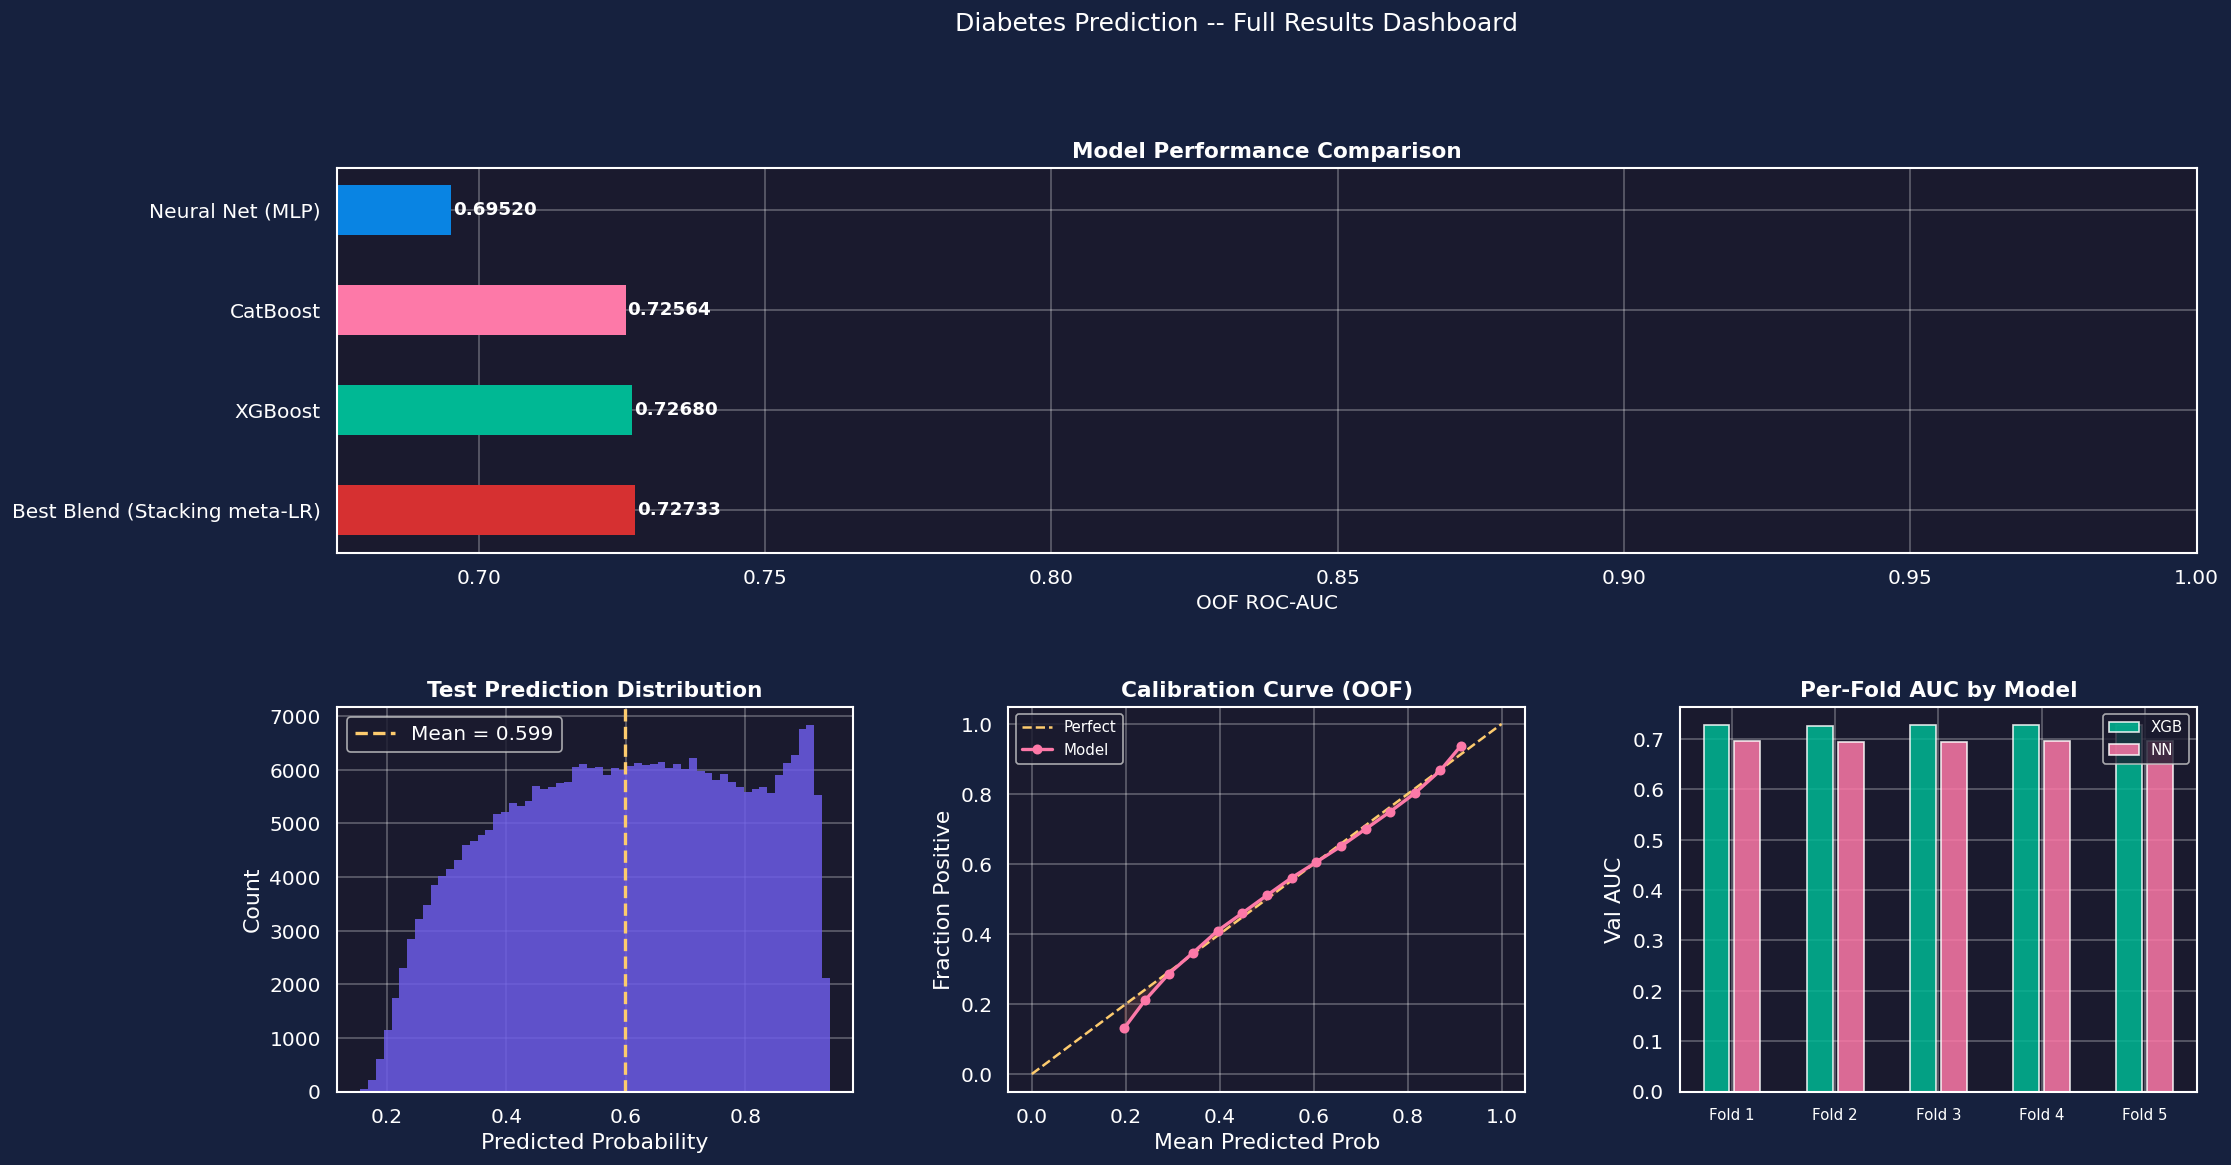

In [22]:
# All model OOF AUCs
all_scores = {
    'XGBoost'          : roc_auc_score(y, oof_preds['xgb']),
    'CatBoost'         : roc_auc_score(y, oof_preds['cat']),
    'Neural Net (MLP)' : oof_nn_auc,
    f'Best Blend ({best_key})': best_auc,
}

summary_df = pd.DataFrame(all_scores.items(), columns=['Model', 'OOF AUC'])
summary_df = summary_df.sort_values('OOF AUC', ascending=False).reset_index(drop=True)

print('=' * 50)
print('       FINAL OOF RESULTS')
print('=' * 50)
print(summary_df.to_string(index=False))
print('=' * 50)

fig = plt.figure(figsize=(20, 10))
gs  = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)

# Panel 1: AUC comparison
ax1 = fig.add_subplot(gs[0, :])
bcolors = ['#D63031' if 'Blend' in m else PALETTE[i % len(PALETTE)]
           for i, m in enumerate(summary_df['Model'])]
bars = ax1.barh(summary_df['Model'], summary_df['OOF AUC'],
                color=bcolors, edgecolor='none', height=0.5)
for bar, val in zip(bars, summary_df['OOF AUC']):
    ax1.text(val + 0.0003, bar.get_y() + bar.get_height()/2,
             f'{val:.5f}', va='center', fontsize=11, weight='bold', color='white')
ax1.set_xlim(summary_df['OOF AUC'].min() - 0.02, 1.0)
ax1.set_xlabel('OOF ROC-AUC', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=13)

# Panel 2: Prediction distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(test_final_probs, bins=60, color='#6C5CE7', edgecolor='none', alpha=0.85)
ax2.axvline(test_final_probs.mean(), color='#FDCB6E', linestyle='--', linewidth=2,
            label=f'Mean = {test_final_probs.mean():.3f}')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')
ax2.set_title('Test Prediction Distribution')
ax2.legend()

# Panel 3: Calibration curve
ax3 = fig.add_subplot(gs[1, 1])
bins_cal = np.linspace(0, 1, 20)
best_oof_blend = stack_oof if best_key == 'Stacking meta-LR' else (
    best_weights[0] * oof_preds['xgb'] +
    best_weights[1] * oof_preds['cat'] +
    best_weights[2] * oof_nn
)
binned = np.digitize(best_oof_blend, bins_cal) - 1
cal_x, cal_y = [], []
for b in range(len(bins_cal) - 1):
    mask = binned == b
    if mask.sum() > 10:
        cal_x.append(best_oof_blend[mask].mean())
        cal_y.append(y[mask].mean())
cal_x, cal_y = np.array(cal_x), np.array(cal_y)
ax3.plot([0, 1], [0, 1], '--', color='#FDCB6E', linewidth=1.5, label='Perfect')
ax3.plot(cal_x, cal_y, 'o-', color='#FD79A8', linewidth=2, markersize=5, label='Model')
ax3.fill_between(cal_x, cal_y, cal_x, alpha=0.15, color='#E17055')
ax3.set_xlabel('Mean Predicted Prob')
ax3.set_ylabel('Fraction Positive')
ax3.set_title('Calibration Curve (OOF)')
ax3.legend(fontsize=9)

# Panel 4: Per-fold AUC
ax4 = fig.add_subplot(gs[1, 2])
x_pos = np.arange(N_FOLDS)
ax4.bar(x_pos - 0.15, [x[1] for x in fold_aucs_all['xgb']], 0.25,
        color='#00B894', label='XGB', alpha=0.85)
ax4.bar(x_pos + 0.15, nn_aucs, 0.25,
        color='#FD79A8', label='NN', alpha=0.85)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)], fontsize=9)
ax4.set_ylabel('Val AUC')
ax4.set_title('Per-Fold AUC by Model')
ax4.legend(fontsize=9)

fig.suptitle('Diabetes Prediction -- Full Results Dashboard', fontsize=15,
             color='white', y=1.01)
plt.show()

## 13.  Submission

In [23]:
submission = pd.DataFrame({
    'id'                : test_ids,
    'diagnosed_diabetes': test_final_probs,
})

submission.to_csv('submission.csv', index=False)

print(f' submission.csv saved!')
print(f'   Shape        : {submission.shape}')
print(f'   Prob range   : [{test_final_probs.min():.4f}, {test_final_probs.max():.4f}]')
print(f'   Mean prob    : {test_final_probs.mean():.4f}')
print(f'   Best OOF AUC : {best_auc:.5f}')

submission.head(10)

 submission.csv saved!
   Shape        : (300000, 2)
   Prob range   : [0.1557, 0.9414]
   Mean prob    : 0.5991
   Best OOF AUC : 0.72733


,id,diagnosed_diabetes
0,700000,0.466350
1,700001,0.718080
2,700002,0.806948
3,700003,0.356853
4,700004,0.923650
5,700005,0.635166
6,700006,0.770455
7,700007,0.914423
8,700008,0.576556
9,700009,0.874574
